In [140]:
import numpy as np
import os
import math
import seaborn as sns

In [141]:
import warnings
warnings.filterwarnings('ignore')

## Реализации функций вычисления статистических параметров и критериев

In [142]:
def read_from_file(filename):
    with open(filename) as f:
        lines = f.readlines()
    input_file = "".join(lines)
    return input_file

In [143]:
def get_personally_generated_sequence(filename=None):
    if filename is None:
        print("Введите путь к файлу со сгенерированной последовательностью:")
        filename = input()
    input_file = read_from_file(filename)
    input_file = input_file.split(",")
    sequence = [int(elem) for elem in input_file if len(elem) != 0]

    # нормализую
    sequence = [elem / 1023 for elem in sequence]
    return sequence

In [144]:
a = get_personally_generated_sequence("../rnd.dat")

### Математическое ожидание

In [145]:
def calculate_expected_value(seq):
    elements_count = {}
    # iterating over the elements for frequency
    for element in seq:
    # checking whether it is in the dict or not
        if element in elements_count:
            # incerementing the count by 1
            elements_count[element] += 1
        else:
            # setting the count to 1
            elements_count[element] = 1

    elements_probs = {k: v / len(seq) for k, v in elements_count.items()}
    
    values = np.array(list(elements_probs.keys()))
    weights = np.array(list(elements_probs.values()))
    return (values * weights).sum() / weights.sum()

In [146]:
expected_value = calculate_expected_value(a)

In [147]:
expected_value

0.00840156402737048

In [148]:
arr_a = np.array(a)

### Среднеквадратичное отклонение

In [149]:
def calculate_standard_deviation(seq):
    # arr_seq = np.array(seq)
    mean_seq = calculate_expected_value(seq)
    return math.sqrt(sum([(elem - mean_seq) ** 2 for elem in seq]) / len(seq))

In [150]:
calculate_standard_deviation(a) # a - это исследуемая последовательность

0.0040441824878797656

### Отрисовка графиков

In [151]:
def plot_mean_graph(seq, step=1):
    seq_amounts = []
    amount_to_mean = []
    for i in range(50, 0, -step):
        cur_value_amount = len(seq) // i
        seq_amounts.append(cur_value_amount)
        seq = np.array(seq)
        cur_value_mean = calculate_expected_value(seq[:cur_value_amount])
        amount_to_mean.append(cur_value_mean)
    
    sns.lineplot(seq_amounts, amount_to_mean)

In [152]:
def plot_std_graph(seq, step=1):
    seq_amounts = []
    amount_to_std = []
    for i in range(50, 0, -step):
        cur_value_amount = len(seq) // i
        seq_amounts.append(cur_value_amount)
        cur_value_std = calculate_standard_deviation(seq[:cur_value_amount])
        amount_to_std.append(cur_value_std)
    
    sns.lineplot(seq_amounts, amount_to_std)

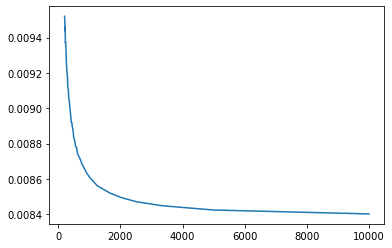

In [153]:
plot_mean_graph(a) # a - это исследуемая последовательность

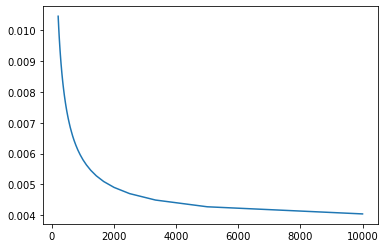

In [154]:
plot_std_graph(a) # a - это исследуемая последовательность

### Относительные погрешности

Целевое мат. ожидание: $0.5$

Целевое std: $0.2887$

In [155]:
def get_relative_errors(seq):
    GOAL_MEAN = 0.5
    GOAL_STD = 0.2887
    cur_value_mean = calculate_expected_value(seq)
    cur_value_std = calculate_standard_deviation(seq)
    print("Относительная погрешность мат. ожидания: ", abs(GOAL_MEAN - cur_value_mean))
    print("Относительная погрешность среднекв. отклонения: ", abs(GOAL_STD - cur_value_std))


In [156]:
get_relative_errors(a) # a - это исследуемая последовательность

Относительная погрешность мат. ожидания:  0.49159843597262953
Относительная погрешность среднекв. отклонения:  0.28465581751212027


In [157]:
import scipy

### Критерий хи-квадрат

In [158]:
def chi_square(seq, p=0.05, given_seqs_n_k=None):
    if given_seqs_n_k is not None:
        theor, emp, k = given_seqs_n_k
        chi_sq = sum([((theor[i] - emp[i]) ** 2) / theor[i] for i in range(len(theor))])
    else:
        n = len(seq)
        k = math.ceil(1 + 1.4 * math.log(n))
        intervals = list(np.linspace(0, 1, k))
        interval_pairs = []
        for i in range(len(intervals) - 1):
            interval_pairs.append((intervals[i], intervals[i + 1]))
        
        interval_cnts = {}
        for pair_a, pair_b in interval_pairs:
            cur_cnt = 0
            for elem in seq:
                if pair_a <= elem < pair_b:
                    cur_cnt += 1
            interval_cnts[f"{pair_a}-{pair_b}"] = cur_cnt
        
        est = round(n / k, 3)
        chi_sq = sum([((v - est) ** 2) / est for _, v in interval_cnts.items()])

    chi_crit = round(scipy.stats.chi2.ppf(1 - p, df=(k - 1)), 4)
    return chi_sq <= chi_crit

In [159]:
chi_square(a) # a - это исследуемая последовательность

False

### Критерий серий

Следующие критерии подразумевают анализ последовательностей, в которых только целые числа. Для этого необходимо имеющуюся последовательность действительных чисел преобразовать в последовательность целых чисел. Это делает функция ниже (real_seq_to_integer).

In [160]:
def real_seq_to_integer(seq, d):
    int_seq = [math.floor(elem * d) for elem in seq if elem < 1]
    return int_seq

In [161]:
def serial_test(seq):
    d = 8
    int_seq = real_seq_to_integer(seq, d)
    n = len(int_seq)

    theor = [n / (2 * d * d)] * d * d

    emp = [0] * d * d
    half_n = n // 2
    for i in range(half_n):
        q, r = int_seq[2 * i], int_seq[2 * i + 1]
        emp[q * d + r] += 1

    return chi_square(None, given_seqs_n_k=(theor, emp, d * d))


In [162]:
serial_test(a) # a - это исследуемая последовательность

False

### Критерий интервалов

In [163]:
def interval_test(seq):
    d = 16
    j, s, emp = -1, 0, 8 * [0]
    t = 7
    
    int_seq = real_seq_to_integer(seq, d)
    n = len(int_seq)
    
    interval_amount = n / 10


    half = 0.5
    theor = [interval_amount * half * (1.0 - half) ** r for r in range(t)] + [interval_amount * (1.0 - half) ** t]


    while s != interval_amount and j != n:
        j += 1
        r = 0
        while j != n and int_seq[j] < d / 2:
            j += 1
            r += 1

        emp[min(r, t)] += 1
        s += 1

    if j == n:
        # print("Все отрезки найдены")
        return False

    return chi_square(None, given_seqs_n_k=(theor, emp, t + 1))

In [164]:
interval_test(a) # a - это исследуемая последовательность

False

### Критерий разбиений

In [165]:
import functools

In [166]:
def count_stirling(n, k):
    if n <= 0:
        return 1
    elif k <= 0:
        return 0
    elif n < k:
        return 0
    elif n != 0 and n == k:
        return 1
    elif n == 0 and k == 0:
        return -1
    else:
        temp = count_stirling(n - 1, k)
        temp *= k
        return k * (count_stirling(n - 1, k)) + count_stirling(n - 1, k - 1)

In [167]:
def partitions_test(seq):
    d = 16
    group_part = 5
    emp = group_part * [0]
    int_seq = real_seq_to_integer(seq, d)
    n = len(int_seq)

    theor = group_part * [0]
    for r in range(1, group_part + 1):
        p = 1.0
        for i in range(r):
            p *= d - i
        theor[r - 1] = (n / group_part) * (p / d ** group_part) * count_stirling(group_part, r)

    for i in range(n // group_part):
        hand = int_seq[i * group_part:i * group_part + group_part]
        unique_value = [v in hand for v in range(d)]
        distinct = functools.reduce(lambda a, b: a + b, unique_value, 0)
        emp[distinct - 1] += 1

    return chi_square(None, given_seqs_n_k=(theor, emp, group_part))


In [168]:
partitions_test(a)

False

### Критерий перестановок

In [169]:
def permutation_test(seq):
    # t - количество перестановок
    t = 3
    d = 1024

    int_seq = real_seq_to_integer(seq, d)
    n = len(int_seq)

    factoral_t = math.factorial(t)
    
    theor = factoral_t * [n / t / factoral_t]

    emp = factoral_t * [0]
    for i in range(n // t):
        cur_group = int_seq[t * i: t * i + t]
        category = t * [0]
        r = t
        while r > 0:
            s = 0
            for j in range(r):
                s = j if cur_group[j] > cur_group[s] else s
            cur_group[s], cur_group[r - 1] = cur_group[r - 1], cur_group[s]
            category[r - 1] = s
            r -= 1
        f = 0
        for j in range(t - 1):
            f = (j + 2) * (f + category[j])
        f += category[t - 1]
        emp[f] += 1

    return chi_square(None, given_seqs_n_k=(theor, emp, factoral_t))

In [170]:
permutation_test(a)

False

In [171]:
def check_test(seq):
    print("Критерий Хи-квадрат:", chi_square(seq))
    print("Критерий серий:", serial_test(seq))
    print("Критерий интервалов:", interval_test(seq))
    print("Критерий разбиений:", partitions_test(seq))
    print("Критерий перестановок:", permutation_test(seq))

### Критерий монотонности и критерий конфликтов не реализованы

## Статистические свойства последовательностей каждого из ГПСЧ

### Линейный конгруентный генератор
|
Использованные параметры при генерации: /i:31104,625,6571,32

In [172]:
a = get_personally_generated_sequence("../seqs/lc.dat")
print("Математическое ожидание: ", calculate_expected_value(a))
print("Среднеквадратическое отклонение: ", calculate_standard_deviation(a))

Математическое ожидание:  0.46498184981110885
Среднеквадратическое отклонение:  0.28327185949924133


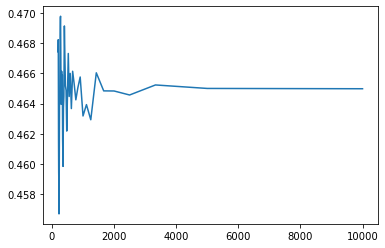

In [173]:
# Зависимость значения мат. ожидания от объёма выборки. Ось X соответствует объёму выборки
plot_mean_graph(a)

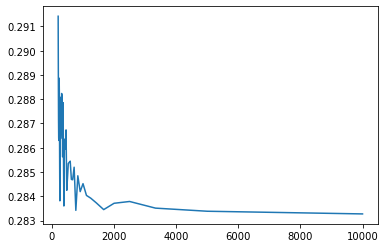

In [174]:
# Зависимость значения среднеквадратического отклонения от объёма выборки. Ось X соответствует объёму выборки
plot_std_graph(a)

In [175]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  0.03501815018889115
Относительная погрешность среднекв. отклонения:  0.0054281405007586825


In [176]:
check_test(a)

Критерий Хи-квадрат: False
Критерий серий: False
Критерий интервалов: False
Критерий разбиений: False
Критерий перестановок: False


### Аддитивный генератор

Использованные параметры при генерации: /i:255,4,3,2,6,7,12,33,41

In [177]:
a = get_personally_generated_sequence("../seqs/add.dat")
print("Математическое ожидание: ", calculate_expected_value(a))
print("Среднеквадратическое отклонение: ", calculate_standard_deviation(a))

Математическое ожидание:  0.1205996832008322
Среднеквадратическое отклонение:  0.07584297556302134


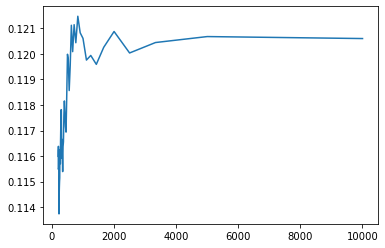

In [178]:
# Зависимость значения мат. ожидания от объёма выборки. Ось X соответствует объёму выборки
plot_mean_graph(a)

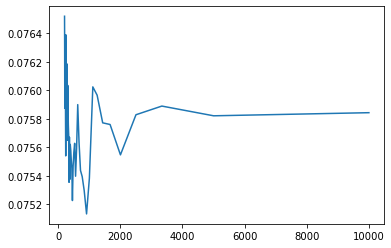

In [179]:
# Зависимость значения среднеквадратического отклонения от объёма выборки. Ось X соответствует объёму выборки
plot_std_graph(a)

In [180]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  0.3794003167991678
Относительная погрешность среднекв. отклонения:  0.21285702443697868


In [181]:
check_test(a)

Критерий Хи-квадрат: False
Критерий серий: False
Критерий интервалов: False
Критерий разбиений: False
Критерий перестановок: False


### Пятипараметрический генератор

Использованные параметры при генерации: /i:4,1,2,13,32,133

In [182]:
a = get_personally_generated_sequence("../seqs/5p.dat")
print("Математическое ожидание: ", calculate_expected_value(a))
print("Среднеквадратическое отклонение: ", calculate_standard_deviation(a))

Математическое ожидание:  0.00840156402737048
Среднеквадратическое отклонение:  0.0040441824878797656


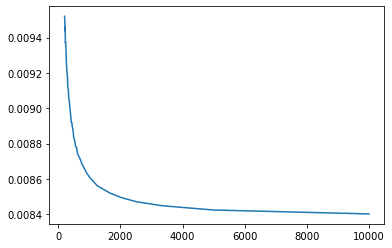

In [183]:
# Зависимость значения мат. ожидания от объёма выборки. Ось X соответствует объёму выборки
plot_mean_graph(a)

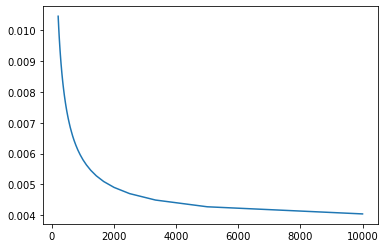

In [184]:
# Зависимость значения среднеквадратического отклонения от объёма выборки. Ось X соответствует объёму выборки
plot_std_graph(a)

In [185]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  0.49159843597262953
Относительная погрешность среднекв. отклонения:  0.28465581751212027


In [186]:
check_test(a)

Критерий Хи-квадрат: False
Критерий серий: False
Критерий интервалов: False
Критерий разбиений: False
Критерий перестановок: False


### РСЛОС

Использованные параметры при генерации: /i:00000000000000000000000000000001,00000000000000000000000000000011

In [187]:
a = get_personally_generated_sequence("../seqs/lfsr.dat")
print("Математическое ожидание: ", calculate_expected_value(a))
print("Среднеквадратическое отклонение: ", calculate_standard_deviation(a))

Математическое ожидание:  0.062400391006842616
Среднеквадратическое отклонение:  0.1654302252079233


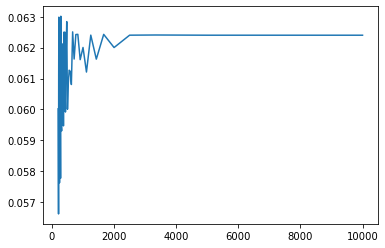

In [188]:
# Зависимость значения мат. ожидания от объёма выборки. Ось X соответствует объёму выборки
plot_mean_graph(a)

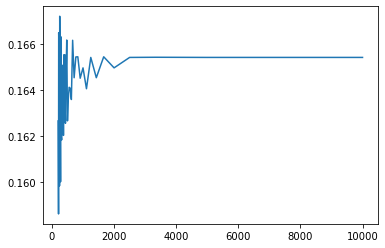

In [189]:
# Зависимость значения среднеквадратического отклонения от объёма выборки. Ось X соответствует объёму выборки
plot_std_graph(a)

In [190]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  0.43759960899315736
Относительная погрешность среднекв. отклонения:  0.12326977479207671


In [191]:
check_test(a)

Критерий Хи-квадрат: False
Критерий серий: False
Критерий интервалов: False
Критерий разбиений: False
Критерий перестановок: False


### Нелинейная комбинация РСЛОС

Использованные параметры при генерации: /i:00000000000000000000000000000001,00000000000000000000000000000001,00000000000000000000000000100001,32,3,4,7

In [192]:
a = get_personally_generated_sequence("../seqs/nfsr.dat")
print("Математическое ожидание: ", calculate_expected_value(a))
print("Среднеквадратическое отклонение: ", calculate_standard_deviation(a))

Математическое ожидание:  0.47858338220918867
Среднеквадратическое отклонение:  0.2972869036092801


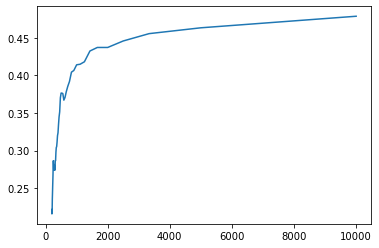

In [193]:
# Зависимость значения мат. ожидания от объёма выборки. Ось X соответствует объёму выборки
plot_mean_graph(a)

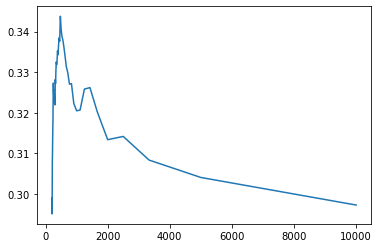

In [194]:
# Зависимость значения среднеквадратического отклонения от объёма выборки. Ось X соответствует объёму выборки
plot_std_graph(a)

In [195]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  0.021416617790811332
Относительная погрешность среднекв. отклонения:  0.008586903609280105


In [196]:
check_test(a)

Критерий Хи-квадрат: False
Критерий серий: False
Критерий интервалов: False
Критерий разбиений: False
Критерий перестановок: False


### Вихрь Мерсенна

Использованные параметры при генерации: /i:2193,1231

In [197]:
a = get_personally_generated_sequence("../seqs/mt.dat")
print("Математическое ожидание: ", calculate_expected_value(a))
print("Среднеквадратическое отклонение: ", calculate_standard_deviation(a))

Математическое ожидание:  0.4706837234165147
Среднеквадратическое отклонение:  0.30043812952886556


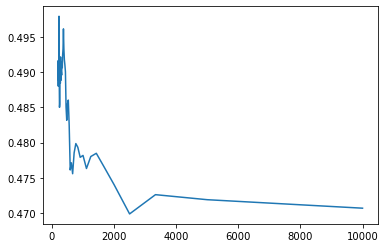

In [198]:
# Зависимость значения мат. ожидания от объёма выборки. Ось X соответствует объёму выборки
plot_mean_graph(a)

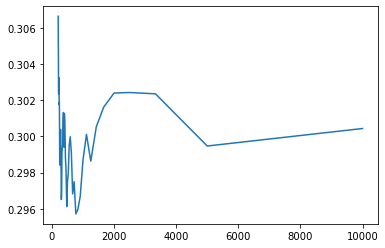

In [199]:
# Зависимость значения среднеквадратического отклонения от объёма выборки. Ось X соответствует объёму выборки
plot_std_graph(a)

In [200]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  0.02931627658348529
Относительная погрешность среднекв. отклонения:  0.011738129528865549


In [201]:
check_test(a)

Критерий Хи-квадрат: False
Критерий серий: False
Критерий интервалов: False
Критерий разбиений: True
Критерий перестановок: True


### RC4

Использованные параметры при генерации: /i:213,968,838,64,355,214,212,36,695,139,897,518,656,956,810,510,985,105,670,8,907,951,685,989,222,931,169,286,289,556,731,902,688,701,771,533,990,630,708,884,255,683,25,214,792,348,34,758,9,781,946,580,615,955,585,5,886,563,81,38,809,444,619,222,544,53,635,621,630,251,497,257,2,467,897,790,728,676,722,838,465,781,10,828,903,235,857,841,146,719,681,678,961,652,491,38,256,909,251,21,110,811,273,25,642,286,489,478,184,812,770,846,241,141,266,500,375,827,633,761,154,663,461,206,529,212,667,342,360,165,523,749,582,803,553,345,786,990,361,702,256,380,234,238,73,965,266,300,847,755,969,681,146,843,125,306,845,752,879,458,788,833,727,817,122,239,765,877,827,327,733,658,644,880,150,474,493,689,670,368,611,263,113,417,834,103,725,754,117,824,623,338,540,337,879,521,183,370,808,120,571,871,301,210,796,744,398,106,845,745,842,876,399,27,105,601,802,831,53,266,157,352,175,303,505,484,994,425,292,729,654,584,860,420,412,49,281,417,703,400,48,404,772,389,733,152,271,585,404,333,381,696,928,609,659,180

In [202]:
a = get_personally_generated_sequence("../seqs/rc4.dat")
print("Математическое ожидание: ", calculate_expected_value(a))
print("Среднеквадратическое отклонение: ", calculate_standard_deviation(a))

Математическое ожидание:  0.1341140889037321
Среднеквадратическое отклонение:  0.10316808287869629


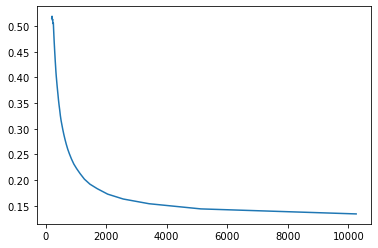

In [203]:
# Зависимость значения мат. ожидания от объёма выборки. Ось X соответствует объёму выборки
plot_mean_graph(a)

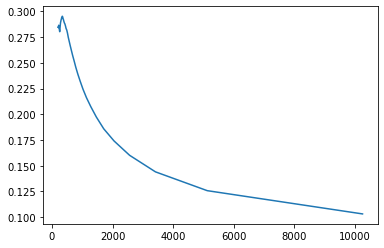

In [204]:
# Зависимость значения среднеквадратического отклонения от объёма выборки. Ось X соответствует объёму выборки
plot_std_graph(a)

In [205]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  0.3658859110962679
Относительная погрешность среднекв. отклонения:  0.18553191712130374


In [206]:
check_test(a)

Критерий Хи-квадрат: False
Критерий серий: False
Критерий интервалов: False
Критерий разбиений: False
Критерий перестановок: True


### RSA

Использованные параметры при генерации: /i:39203,1024,10,12395

In [207]:
a = get_personally_generated_sequence("../seqs/rsa.dat")
print("Математическое ожидание: ", calculate_expected_value(a))
print("Среднеквадратическое отклонение: ", calculate_standard_deviation(a))

Математическое ожидание:  0.6190963503845118
Среднеквадратическое отклонение:  0.27830388914693316


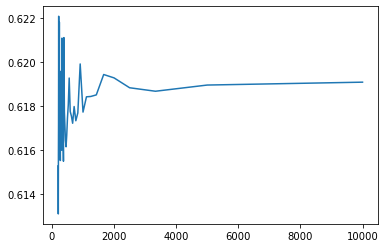

In [208]:
# Зависимость значения мат. ожидания от объёма выборки. Ось X соответствует объёму выборки
plot_mean_graph(a)

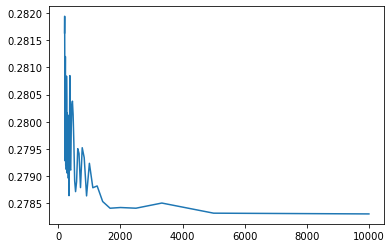

In [209]:
# Зависимость значения среднеквадратического отклонения от объёма выборки. Ось X соответствует объёму выборки
plot_std_graph(a)

In [210]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  0.11909635038451183
Относительная погрешность среднекв. отклонения:  0.010396110853066853


In [211]:
check_test(a)

Критерий Хи-квадрат: False
Критерий серий: False
Критерий интервалов: False
Критерий разбиений: False
Критерий перестановок: False


### Алгоритм Блюма-Блюма-Шуба

Использованные параметры при генерации: /i:3229

In [212]:
a = get_personally_generated_sequence("../seqs/bbs.dat")
print("Математическое ожидание: ", calculate_expected_value(a))
print("Среднеквадратическое отклонение: ", calculate_standard_deviation(a))

Математическое ожидание:  0.5000331833874286
Среднеквадратическое отклонение:  0.3283717367036913


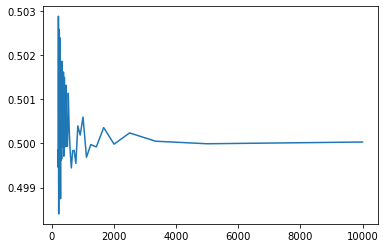

In [213]:
# Зависимость значения мат. ожидания от объёма выборки. Ось X соответствует объёму выборки
plot_mean_graph(a)

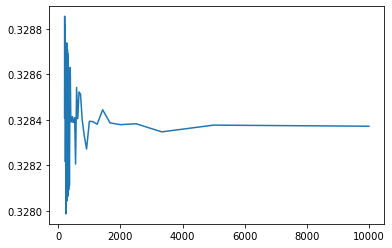

In [214]:
# Зависимость значения среднеквадратического отклонения от объёма выборки. Ось X соответствует объёму выборки
plot_std_graph(a)

In [215]:
get_relative_errors(a)

Относительная погрешность мат. ожидания:  3.318338742863691e-05
Относительная погрешность среднекв. отклонения:  0.039671736703691285


In [216]:
check_test(a)

Критерий Хи-квадрат: False
Критерий серий: False
Критерий интервалов: False
Критерий разбиений: False
Критерий перестановок: False
